In [2]:
import numpy as np
from numpy import dstack
import tensorflow as tf
import operator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
import multiprocessing as mp
import string
import en_core_web_sm
import spacy
from random import randrange
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Embedding,Dense,LSTM,GRU,Bidirectional,Dropout,SimpleRNN,GlobalAvgPool1D,GlobalMaxPool1D
from tensorflow.keras.layers import Conv1D,SpatialDropout1D,BatchNormalization,Lambda,Concatenate,concatenate,GlobalMaxPooling1D
from tensorflow.keras.callbacks import  EarlyStopping
from keras.utils import to_categorical

%matplotlib inline

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
warnings.filterwarnings('ignore')
nlp = en_core_web_sm.load()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Marc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Marc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Marc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Marc\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
df = pd.read_csv('train.csv')
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19579 entries, 0 to 19578
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      19579 non-null  object
 1   text    19579 non-null  object
 2   author  19579 non-null  object
dtypes: object(3)
memory usage: 459.0+ KB


In [6]:

# Removing id column
df.drop('id',axis=1,inplace=True)

In [7]:
#remove outliers
df = df[df['text'].str.split().map(lambda x:len(x))<100]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19488 entries, 0 to 19578
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    19488 non-null  object
 1   author  19488 non-null  object
dtypes: object(2)
memory usage: 456.8+ KB


## Data Cleaning


In [8]:
# a function to preprocess removing punctuations, normalize, stopwords and lemmatization


class TextPreprocessing(BaseEstimator,TransformerMixin):
    def __init__(self,
                 n_jobs=1):    
      
     self.n_jobs = n_jobs
    """
        Text preprocessing transformer includes steps:
            1. Text normalization
            2. Punctuation removal
            3. Stop words removal
            4. Lemmatization
        
        n_jobs - parallel jobs to run
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X, *_):
        X_copy = X.copy()
        partitions = 2
        cores = mp.cpu_count()
        if self.n_jobs <= -1:
          partitions = cores
        elif self.n_jobs <= 0:
          return X_copy.apply(self._preprocess_text)
        else:
          partitions = min(self.n_jobs, cores)
        cores = mp.cpu_count()
        data_split = np.array_split(X_copy, partitions)
        pool = mp.Pool(cores)
        data = pd.concat(pool.map(self._preprocess_part, data_split))
        pool.close()
        pool.join()
        return data

    def _preprocess_part(self, part):
        return part.apply(self._preprocess_text)

    def _preprocess_text(self, text):
        normalized_text = self._normalize(text)
        doc = nlp(normalized_text)
        removed_punct = self._remove_punct(doc)
        removed_stop_words = self._remove_stop_words(removed_punct)
        return self._lemmatize(removed_stop_words)

    def _normalize(self, text):
        # some issues in normalise package
        try:
            return ' '.join(normalise(text, verbose=False))
        except:
            return text
    def _remove_punct(self, doc):
        return [t for t in doc if t.text not in string.punctuation]

    def _remove_stop_words(self, doc):
        return [t for t in doc if not t.is_stop]

    def _lemmatize(self, doc):
        return ' '.join([t.lemma_ for t in doc])

In [9]:
#Converting the categorical column to variable for easier processing 

df['author'] = df['author'].map({'EAP':0,'HPL':1,'MWS':2})
df.head()

,text,author
0,"This process, however, afforded me no means of...",0
1,It never once occurred to me that the fumbling...,1
2,"In his left hand was a gold snuff box, from wh...",0
3,How lovely is spring As we looked from Windsor...,2
4,"Finding nothing else, not even gold, the Super...",1


#### Using countvectorizer to convert the sentence into column of words

In [10]:
cv = CountVectorizer()
cv_df = cv.fit_transform(df['text'])

tfidf = TfidfTransformer()
tfidf.fit(cv_df)
tfidf_trans = tfidf.transform(cv_df)

print('Shape of Sparse Matrix: ', cv_df.shape)
print('Amount of Non-Zero occurences: ', cv_df.nnz)
print('Shape of Tfidf Transformed matrix',tfidf_trans.shape)

Shape of Sparse Matrix:  (19488, 24796)
Amount of Non-Zero occurences:  421231
Shape of Tfidf Transformed matrix (19488, 24796)


# Neural Networks Model



In [11]:
df_neural = df
df_neural.head()

,text,author
0,"This process, however, afforded me no means of...",0
1,It never once occurred to me that the fumbling...,1
2,"In his left hand was a gold snuff box, from wh...",0
3,How lovely is spring As we looked from Windsor...,2
4,"Finding nothing else, not even gold, the Super...",1


In [12]:
stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def convert_nltk_to_wordnet(text):
#To check if the given word is noun,or a verb or an adjective
  if text.startswith('J'):
    return wordnet.ADJ
  
  elif text.startswith('N'):
    return wordnet.NOUN

  elif text.startswith('V'):
    return wordnet.VERB
  
  elif text.startswith('R'):
    return wordnet.ADV
  
  else:
    return None 
 
def lemmatizes(sentence):
  tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
  wordnet_tagged = map(lambda x : (x[0] , convert_nltk_to_wordnet(x[1])) , tagged)
  lemmatized_sentence = []
  for word , tag in wordnet_tagged:
    if tag is None:
      lemmatized_sentence.append(word)
    else:
      lemmatized_sentence.append(lemmatizer.lemmatize(word,tag))
  return ' '.join(lemmatized_sentence)

def clean(text):

  text = re.sub('/.',' ',text)
  text = text.lower()
  text = re.sub("aren't", "are not",text)
  text = re.sub("can't","cannot",text)
  text = re.sub("don't","do not",text)
  text = re.sub("couldn't","could not",text)
  text = re.sub("doesn't","does not",text)
  text = re.sub("hadn't","had not",text)
  text = re.sub("wouldn't","would not",text)
  text = re.sub("he'll","he will",text)
  text = re.sub("what've","what have",text)
  text = re.sub("who'd","who would",text)
  text = re.sub("who'll","who will",text)
  text = re.sub("I'll","I will",text)
  text = re.sub("you'd","you would",text)
  text = re.sub("you'll","you will",text)
  text = re.sub("you're","you are",text)
  text = re.sub("you've","you have",text)
  text = re.sub("wasn't","was not",text)
  text = re.sub("that's","that is",text)
  text = re.sub("they've","they have",text)
  text = re.sub("they're","they are",text)
  text = re.sub("what's","what is",text)
  text = re.sub("what're","what are",text)
  text = re.sub("what'll","what will",text)
  text = re.sub("that's","that is",text)
  text = re.sub("there's","there is",text)
  text = re.sub("it's","it is",text)
  text = re.sub("it'll","it will",text)
  text = re.sub("could've","could have",text)
  text = re.sub("it'll","it will",text)
  text = re.sub("shouldn't","should not",text)
  text = re.sub("should've","should have",text)
  text = re.sub("shan't","shall not",text)
  text = re.sub("won't","will not",text)
  text = re.sub("we'd","we would",text)
  text = re.sub("weren't","were not",text)
  text = re.sub('[^A-Za-z/.\s]','',text)
  text = text.lower().split()
  text = [word for word in text if word not in stop]
  text = ' '.join(text)
  final_text = lemmatizes(text)
  return final_text

df_neural['text'] = df_neural['text'].apply(lambda x : clean(x))
y = to_categorical(df['author'])
df_neural.head()

,text,author
0,process however afford mean ascertain dimensio...,0
1,never occur fumble might mere mistake .,1
2,left hand gold snuff box caper hill cut manner...,0
3,lovely spring look windsor terrace sixteen fer...,2
4,find nothing else even gold superintendent aba...,1


In [13]:
def get_embedding(name,word_index,vocab_len,dim):
  embedding_index = {}
  f = open(name,encoding='utf-8')
  for line in f:
    values = line.split()
    word = values[0]
    coeffs = np.asarray(values[1:],dtype='float32')
    embedding_index[word] = coeffs
  f.close()
  embedding_matrix = np.zeros((vocab_len+1,dim))
  for word,index in word_index.items():
    if index > vocab_len:
      break
    else:
      embedding_vector = embedding_index.get(word)
      if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
  return embedding_matrix,embedding_index

In [14]:
corpus = np.asarray(df_neural['text'])
tokenizer = Tokenizer(num_words=21000)
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)
data = pad_sequences(sequences=sequences,padding='pre')
vocab_len = len(tokenizer.word_index)+1
max_len = len(data[0])

In [15]:
word_index = tokenizer.word_index
embedding_matrix1,embedding_index1 = get_embedding('glove.6B.300d.txt',word_index,vocab_len,300)

In [16]:
embedding_matrix2,embedding_index2 = get_embedding('wiki-news-300d-1M.vec',word_index,vocab_len,300)

In [17]:
# Checking if we have word embeddings for the words in our vocab
def check_coverage(vocab, embeddings_index):

  known_words = {}
  unknown_words = {}
  nb_known_words = 0
  nb_unknown_words = 0
  for word in vocab.keys():
    try:
        known_words[word] = embeddings_index[word]
        nb_known_words += vocab[word]
    except:
        unknown_words[word] = vocab[word]
        nb_unknown_words += vocab[word]
        pass
  print('Found embeddings for {:.3%} of vocab'.format(len(known_words) / len(vocab)))
  print('Found embeddings for  {:.3%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
  unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

  return unknown_words

In [18]:
print('Glove embeddings:\n')
Glove_embedding = check_coverage(word_index,embedding_index1)
print('\n')
print('Fasttext embeddings:\n')
Fasttext_embedding = check_coverage(word_index,embedding_index2)

Glove embeddings:

Found embeddings for 87.348% of vocab
Found embeddings for  82.289% of all text


Fasttext embeddings:

Found embeddings for 81.511% of vocab
Found embeddings for  74.497% of all text


In [19]:
Glove_embedding[:30]

[('brusquerie', 20245),
 ('tremulousness', 20238),
 ('aegidus', 20232),
 ('valentinianus', 20231),
 ('btenoir', 20227),
 ('junianus', 20226),
 ('littlewit', 20224),
 ('schweinkopf', 20219),
 ('apothegm', 20216),
 ('flatzplatz', 20215),
 ('literatim', 20211),
 ('odigies', 20209),
 ('despera', 20208),
 ('chinless', 20207),
 ('herbless', 20202),
 ('trink', 20201),
 ('deathful', 20199),
 ('contemns', 20181),
 ('servox', 20171),
 ('unpossessed', 20170),
 ('signalize', 20153),
 ('carvins', 20149),
 ('otaheit', 20146),
 ('miltonic', 20136),
 ('rayless', 20135),
 ('siroc', 20129),
 ('lascia', 20125),
 ('raggiar', 20124),
 ('lombra', 20121),
 ('othair', 20115)]

In [20]:

embedding_matrix_weights = np.mean((embedding_matrix1,embedding_matrix2),axis=0)
np.shape(embedding_matrix_weights)

(20252, 300)

In [21]:

import pickle

def save_history_to_pickle(history, filename):
    """
    Save the training history object to a pickle file.

    Parameters:
    - history: The training history object returned by model.fit().
    - filename: The name of the file to save the history object.
    """
    with open(filename, 'wb') as f:
        pickle.dump(history.history, f)
    print(f"Training history saved to '{filename}'.")

# Example usage:
# save_history_to_pickle(history, 'model_history.pkl')

In [22]:

# Split the data into training ,test and validation set
X_train,X_test,y_train,y_test=train_test_split(data,y,test_size=0.2)

In [23]:
def plot_confusion_matrix(y_test,y_pred, model_name):
    labels = ['EAP', 'HPL', 'MWS']
    cm = confusion_matrix(y_test.argmax(1), y_pred.argmax(1))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix of {model_name}')
    plt.show()

In [24]:
# using BiDirectional LSTM model (only one)

def deep_1st():
  model_deep = Sequential()
  model_deep.add(Embedding(vocab_len+1,300,weights=[embedding_matrix_weights],trainable=True,input_length=max_len))
  model_deep.add(SpatialDropout1D(0.2))
  model_deep.add(Bidirectional(LSTM(128,return_sequences = True)))
  model_deep.add(Bidirectional(LSTM(64,return_sequences=True)))
  model_deep.add(GlobalMaxPool1D())
  model_deep.add(Dense(128,activation='relu'))
  model_deep.add(Dropout(0.5))
  model_deep.add(BatchNormalization())
  model_deep.add(Dense(3,activation='softmax'))

  callbacks = EarlyStopping(monitor='val_loss',patience=5)

  model_deep.compile(optimizer = 'adam',loss='categorical_crossentropy',metrics=['accuracy'])
  return model_deep

In [25]:
kfold = StratifiedKFold(n_splits=5,shuffle=True)
i=1
score=[]
for train_index , test_index in kfold.split(X_train,y_train.argmax(1)):
    print(f'{i} of KFold {kfold.n_splits}')
    X_train1,X_test1 = X_train[train_index],X_train[test_index]
    y_train1,y_test1 = y_train[train_index],y_train[test_index]
    model_1 = deep_1st()
    history = model_1.fit(X_train1,y_train1,batch_size=512,epochs=5,validation_split=0.2)
    save_history_to_pickle(history, 'model_1_history_v2.pkl')
    print('\n')
    acc = model_1.evaluate(X_test1,y_test1)
    print('Accuracy :  ',acc[1])
    score.append(acc[1])
    print('\n')
    i+=1

1 of KFold 5
Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.4457 - loss: 1.1442 - val_accuracy: 0.4172 - val_loss: 1.0558
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.6543 - loss: 0.7857 - val_accuracy: 0.4525 - val_loss: 1.0030
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7509 - loss: 0.6018 - val_accuracy: 0.5255 - val_loss: 0.9429
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.8275 - loss: 0.4405 - val_accuracy: 0.6725 - val_loss: 0.8471
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8824 - loss: 0.3235 - val_accuracy: 0.7094 - val_loss: 0.7629
Training history saved to 'model_1_history_v2.pkl'.


98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.6929 - loss: 0.7716
Accuracy :   0.7023733258247375


2 of KFold 5
Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.4301 - loss: 1.1787 - val_accuracy: 0.4830 - val_loss: 1.0472
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0

In [26]:
pred = model_1.predict(X_test)


print(classification_report(y_test.argmax(1),pred.argmax(1)))

122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step
              precision    recall  f1-score   support

           0       0.58      0.97      0.73      1590
           1       0.98      0.40      0.57      1081
           2       0.88      0.56      0.69      1227

    accuracy                           0.69      3898
   macro avg       0.81      0.65      0.66      3898
weighted avg       0.79      0.69      0.67      3898



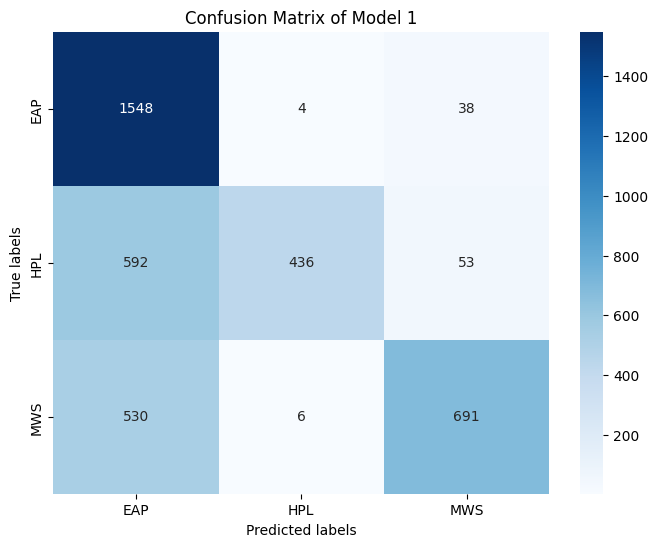

In [27]:
plot_confusion_matrix(y_test,pred,'Model 1')

In [28]:
model_1.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 64, 300)        │     6,075,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_4             │ (None, 64, 300)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 64, 256)        │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 64, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_4          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,089,467 (76.64 MB)

 Trainable params: 6,696,403 (25.54 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 13,392,808 (51.09 MB)

Since the training data set is small , it is preferred to put trainable = False

In [29]:
def model_true():

  inp = Input(shape=(max_len,))
  x = Embedding(vocab_len+1, 300, weights=[embedding_matrix_weights], trainable=True)(inp)
  x = SpatialDropout1D(0.3)(x)
  x1 = Bidirectional(LSTM(256, return_sequences=True))(x)
  x2 = Bidirectional(GRU(128, return_sequences=True))(x1)
  max_pool1 = GlobalMaxPool1D()(x1)
  max_pool2 = GlobalMaxPool1D()(x2)
  conc = concatenate([max_pool1, max_pool2])
  x = Dense(128,activation='relu')(conc)
  x = Dropout(0.5)(x)
  predictions = Dense(3, activation='softmax')(x)

  model = Model(inputs=inp, outputs=predictions)
  callbacks = EarlyStopping(monitor='val_loss',patience=3)

  from tensorflow.keras.optimizers import Adam,RMSprop
  adam = Adam()
  model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [30]:
kfold=StratifiedKFold(n_splits=5,shuffle=True)
score=[]
i=1
for train_index , test_index in kfold.split(X_train,y_train.argmax(1)):
    print(f'{i} of KFold {kfold.n_splits}')
    X_train_main,X_val = X_train[train_index],X_train[test_index]
    y_train_main,y_val = y_train[train_index],y_train[test_index]
    model_2nd = model_true()
    history = model_2nd.fit(X_train_main,y_train_main,epochs=5,batch_size=128,validation_split=0.2)
    save_history_to_pickle(history, 'model_2_history.pkl')
    print('\n')
    acc = model_2nd.evaluate(X_val,y_val)
    score.append(acc[1])
    print('Accuracy:  ',acc[1])
    i+=1

1 of KFold 5
Epoch 1/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.5219 - loss: 0.9668 - val_accuracy: 0.7359 - val_loss: 0.6504
Epoch 2/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.7829 - loss: 0.5549 - val_accuracy: 0.7916 - val_loss: 0.5203
Epoch 3/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.8707 - loss: 0.3415 - val_accuracy: 0.7968 - val_loss: 0.5044
Epoch 4/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9170 - loss: 0.2333 - val_accuracy: 0.7912 - val_loss: 0.5800
Epoch 5/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9459 - loss: 0.1461 - val_accuracy: 0.7868 - val_loss: 0.6654
Training history saved to 'model_2_history.pkl'.


98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.7761 - loss: 0.6709
Accuracy:   0.7780628800392151
2 of KFold 5
Epoch 1/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.5075 - loss: 0.9746 - val_accuracy: 0.7327 - val_loss: 0.6475
Epoch 2/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.7

In [31]:
print('Accuracy :  ',np.mean(score))

Accuracy :   0.796407949924469


In [32]:
pred_2 = model_2nd.predict(X_test)

print(classification_report(y_test.argmax(1),pred_2.argmax(1)))

122/122 ━━━━━━━━━━━━━━━━━━━━ 23s 183ms/step
              precision    recall  f1-score   support

           0       0.82      0.79      0.80      1590
           1       0.79      0.83      0.81      1081
           2       0.79      0.80      0.79      1227

    accuracy                           0.80      3898
   macro avg       0.80      0.80      0.80      3898
weighted avg       0.80      0.80      0.80      3898



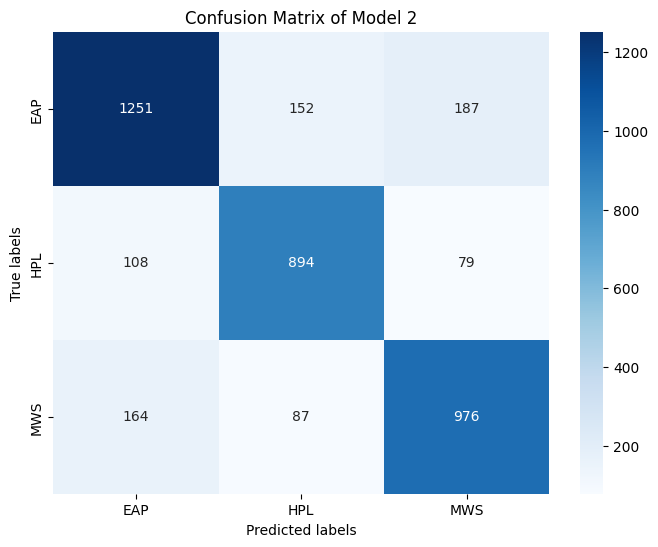

In [33]:
plot_confusion_matrix(y_test,pred_2,'Model 2')

The learning curve of Model 1 shows a sign of underfitting because the validation loss is greater than the training loss. Further configuration of layers is needed to reduce the loss incured during training. 

In [34]:
embedding_axis1 = np.concatenate((embedding_matrix1,embedding_matrix2),axis=1)

In [35]:
def model_3():

  sequence_input = Input(shape=(max_len,))
  embedding_layer = Embedding(vocab_len+1,600,weights=[embedding_axis1],trainable = True,input_length=max_len)
  x = embedding_layer(sequence_input)
  x = SpatialDropout1D(0.2)(x)
  x = Bidirectional(LSTM(128,return_sequences=True))(x)
  x = Conv1D(64,kernel_size=2,padding='valid',kernel_initializer="he_uniform")(x)
  avg_pool = GlobalAvgPool1D()(x)
  max_pool = GlobalMaxPool1D()(x)
  x = concatenate([avg_pool,max_pool])
  x = Dense(128,activation='relu')(x)
  x = Dropout(0.5)(x)
  pred = Dense(3,activation='softmax')(x)

  model_3 = Model(sequence_input, pred)
  model_3.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

  # shows the architecture and parameters of the model
  return model_3

In [36]:
kfold=StratifiedKFold(n_splits=5,shuffle=True)
i=1
score=[]
for train_index , test_index in kfold.split(X_train,y_train.argmax(1)):
    print(f'{i} of KFold {kfold.n_splits}')
    X_train_main,X_val = X_train[train_index],X_train[test_index]
    y_train_main,y_val = y_train[train_index],y_train[test_index]
    model_3rd = model_3()
    history = model_3rd.fit(X_train_main,y_train_main,epochs=5,batch_size=512,validation_split=0.2)
    save_history_to_pickle(history, 'model_3_history.pkl')
    print('\n')
    acc = model_3rd.evaluate(X_val,y_val)
    score.append(acc[1])
    print('\n')
    print('Accuracy:  ',acc[1])
    i+=1

1 of KFold 5
Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.4276 - loss: 1.0722 - val_accuracy: 0.6036 - val_loss: 0.9052
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.5877 - loss: 0.9030 - val_accuracy: 0.6000 - val_loss: 0.8704
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.6473 - loss: 0.8048 - val_accuracy: 0.6537 - val_loss: 0.7652
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.6737 - loss: 0.7478 - val_accuracy: 0.6834 - val_loss: 0.7316
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.7002 - loss: 0.7019 - val_accuracy: 0.6882 - val_loss: 0.7163
Training history saved to 'model_3_history.pkl'.


98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.6744 - loss: 0.7289


Accuracy:   0.680243730545044
2 of KFold 5
Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.4165 - loss: 1.0713 - val_accuracy: 0.5295 - val_loss: 0.9512
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.5939

In [37]:
pred_3 = model_3rd.predict(X_test)

print(classification_report(y_test.argmax(1),pred_3.argmax(1)))

122/122 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step
              precision    recall  f1-score   support

           0       0.71      0.77      0.74      1590
           1       0.69      0.71      0.70      1081
           2       0.76      0.65      0.70      1227

    accuracy                           0.72      3898
   macro avg       0.72      0.71      0.71      3898
weighted avg       0.72      0.72      0.72      3898



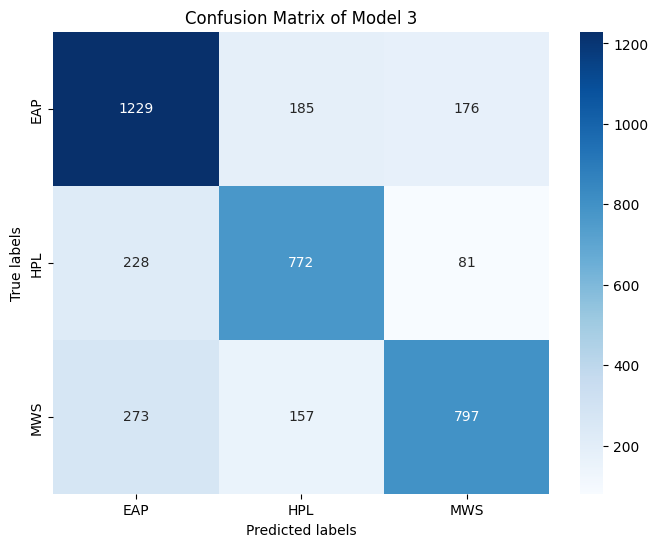

In [38]:
plot_confusion_matrix(y_test,pred_3,'Model 3')

In [39]:
def model_4():

  inp = Input(shape=(max_len,))
  embedding_layer = Embedding(vocab_len+1,600,weights=[embedding_axis1],trainable=True)
  x = embedding_layer(inp)
  x = SpatialDropout1D(0.2)(x)
  x1 = Bidirectional(LSTM(64,return_sequences=True))(x)
  x1 = Conv1D(64 ,kernel_size=3,padding='same',activation='linear')(x1)
  x1 = BatchNormalization()(x1)
  x1 = Conv1D(64,kernel_size=3,padding='same',activation='linear')(x1)
  x1 = BatchNormalization()(x1)
  x2 = Conv1D(64,kernel_size=1,padding='same',activation='linear')(x)
  xmain = concatenate([x1,x2])
  xmain1 = Conv1D(64,kernel_size=3,padding='same',activation='linear')(xmain)
  xmain1 = BatchNormalization()(xmain1)
  xmain1 = Conv1D(64,kernel_size=3,padding='same',activation='linear')(xmain1)
  xmain1 = BatchNormalization()(xmain1)
  x = concatenate([xmain,xmain1])
  x = GlobalMaxPool1D()(x)
  x = Dense(182,activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x)
  x = Dense(3,activation = 'softmax')(x)

  model_last = Model(inp,x)
  model_last.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
  return model_last

In [40]:
kfold=StratifiedKFold(n_splits=5,shuffle=True)
i=1
score=[]
for train_index , test_index in kfold.split(X_train,y_train.argmax(1)):
    print(f'{i} of KFold {kfold.n_splits}')
    X_train_main,X_val = X_train[train_index],X_train[test_index]
    y_train_main,y_val = y_train[train_index],y_train[test_index]
    model_4th = model_4()
    history = model_4th.fit(X_train_main,y_train_main,epochs=5,batch_size=128,validation_split=0.2)
    save_history_to_pickle(history, 'model_4_history.pkl')
    print('\n')
    acc = model_4th.evaluate(X_val,y_val)
    score.append(acc[1])
    print('\n')
    print('Accuracy:  ',acc[1])
    i+=1
     

1 of KFold 5
Epoch 1/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 61s 650ms/step - accuracy: 0.4581 - loss: 1.4096 - val_accuracy: 0.5447 - val_loss: 0.9060
Epoch 2/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 54s 698ms/step - accuracy: 0.6956 - loss: 0.7523 - val_accuracy: 0.5491 - val_loss: 0.9032
Epoch 3/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 51s 658ms/step - accuracy: 0.8394 - loss: 0.4140 - val_accuracy: 0.7475 - val_loss: 0.6166
Epoch 4/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 59s 755ms/step - accuracy: 0.9209 - loss: 0.2245 - val_accuracy: 0.7968 - val_loss: 0.4965
Epoch 5/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 53s 675ms/step - accuracy: 0.9491 - loss: 0.1482 - val_accuracy: 0.7908 - val_loss: 0.5643
Training history saved to 'model_4_history.pkl'.


98/98 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.7878 - loss: 0.5801


Accuracy:   0.7966645359992981
2 of KFold 5
Epoch 1/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 58s 622ms/step - accuracy: 0.4807 - loss: 1.3484 - val_accuracy: 0.5495 - val_loss: 0.9338
Epoch 2/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 46s 593ms/s

In [41]:
print('Accuracy :  ' , np.mean(score))

Accuracy :   0.7727389335632324


In [42]:
pred_4 = model_4th.predict(X_test)

print(classification_report(y_test.argmax(1),pred_4.argmax(1)))

122/122 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step
              precision    recall  f1-score   support

           0       0.73      0.88      0.79      1590
           1       0.89      0.69      0.77      1081
           2       0.81      0.76      0.79      1227

    accuracy                           0.79      3898
   macro avg       0.81      0.77      0.79      3898
weighted avg       0.80      0.79      0.79      3898



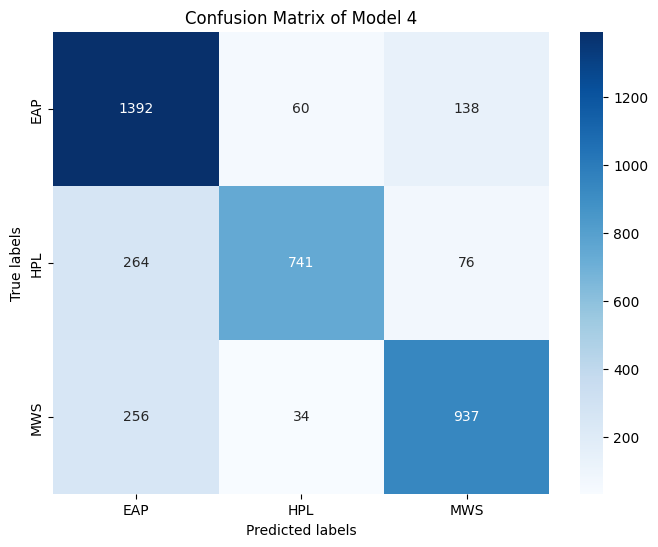

In [43]:
plot_confusion_matrix(y_test,pred_4,'Model 4')

In [44]:
model_4th.summary()

Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_19        │ (None, 64, 600)   │ 12,151,200 │ input_layer_19[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_… │ (None, 64, 600)   │          0 │ embedding_19[0][… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_29    │ (None, 64, 128)   │    340,480 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_25 (Conv1D)  │ (None, 64, 64)    │     24,640 │ bidirectional_29… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64)    │        256 │ conv1d_25[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_26 (Conv1D)  │ (None, 64, 64)    │     12,352 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64)    │        256 │ conv1d_26[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_27 (Conv1D)  │ (None, 64, 64)    │     38,464 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_18      │ (None, 64, 128)   │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ conv1d_27[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 64, 64)    │     24,640 │ concatenate_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64)    │        256 │ conv1d_28[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 64, 64)    │     12,352 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64)    │        256 │ conv1d_29[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_19      │ (None, 64, 192)   │          0 │ concatenate_18[0… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 192)       │          0 │ concatenate_19[0… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 182)       │     35,126 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 182)       │        728 │ dense_38[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 182)       │          0 │ batch_normalizat

 Total params: 37,922,915 (144.66 MB)

 Trainable params: 12,640,679 (48.22 MB)

 Non-trainable params: 876 (3.42 KB)

 Optimizer params: 25,281,360 (96.44 MB)

In [45]:
# a function to plot the learning curve of the models

def plot_learning_curve(history, model_name):
    plt.figure(figsize=(10, 6))
    
    # Extracting training and validation loss from the history object
    training_loss = history['loss']
    validation_loss = history['val_loss']

    # Plotting the training and validation loss for each model
    epochs = range(1, len(training_loss) + 1)
    plt.plot(epochs, training_loss, label=model_name + ' Training loss')
    plt.plot(epochs, validation_loss, label=model_name + ' Validation loss')

    plt.title('Training and Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

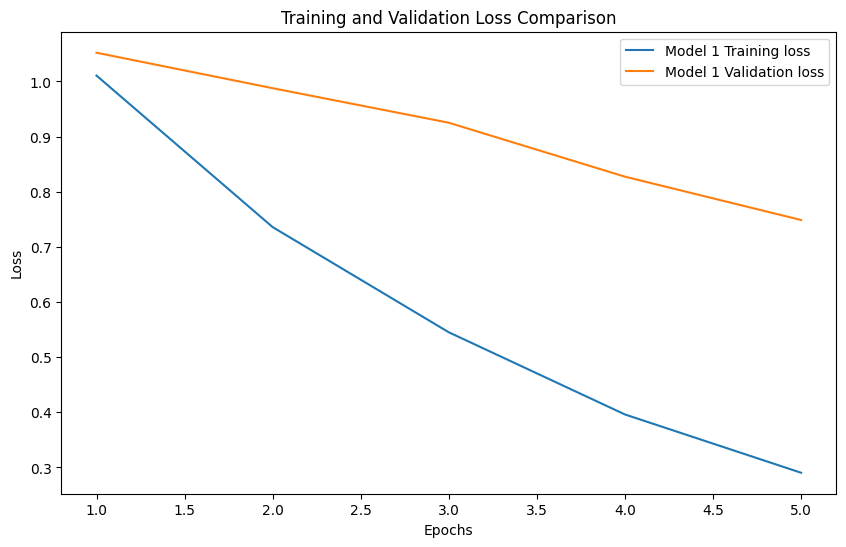

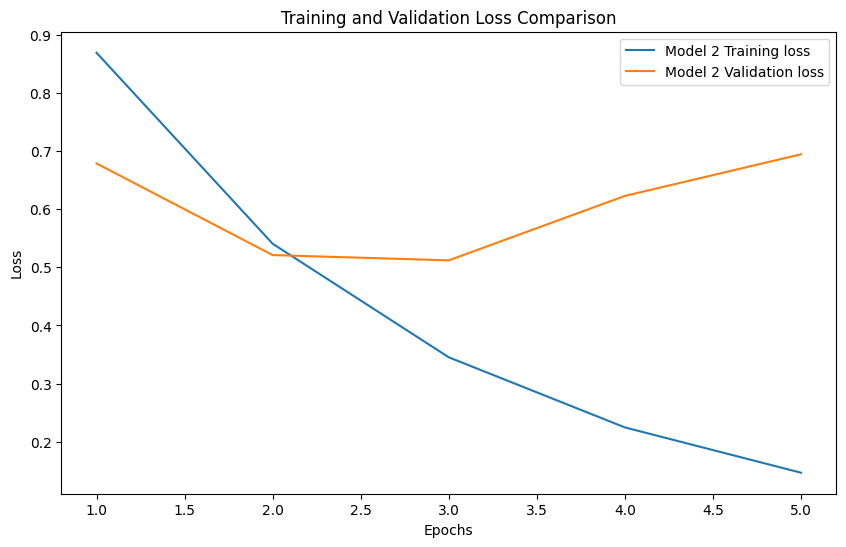

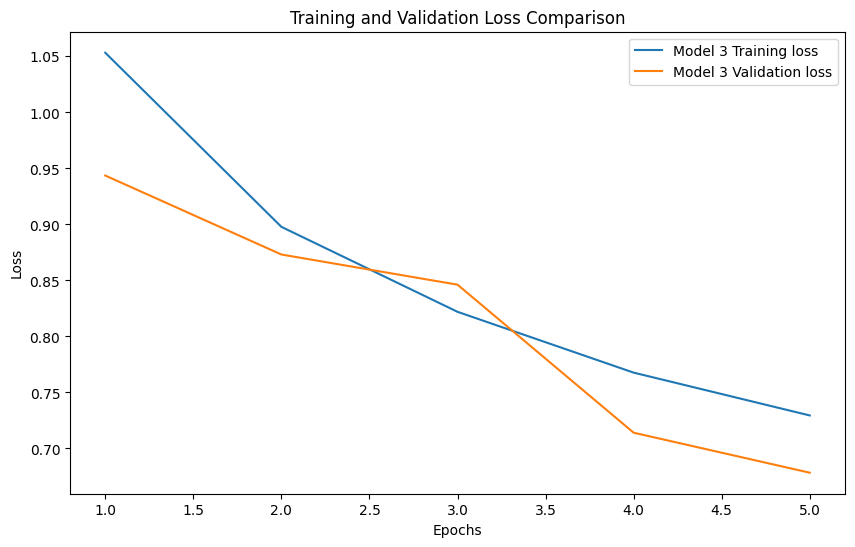

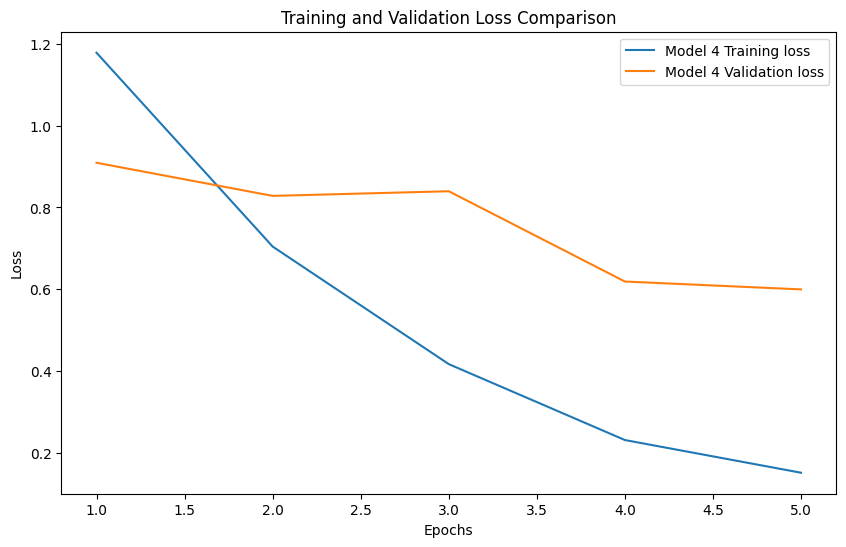

In [46]:
# Load the saved histories
with open('model_1_history.pkl', 'rb') as f:
    model_1_history = pickle.load(f)
with open('model_2_history.pkl', 'rb') as f:
    model_2_history = pickle.load(f)
with open('model_3_history.pkl', 'rb') as f:
    model_3_history = pickle.load(f)
with open('model_4_history.pkl', 'rb') as f:
    model_4_history = pickle.load(f)

    
# Assuming you have loaded all the model histories you want to compare
# Define model names
model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4']

# Create a list of loaded histories
histories = [model_1_history,model_2_history, model_3_history, model_4_history]

# Plot learning curves
for i, history in enumerate(histories):
    plot_learning_curve(history, model_names[i])